<a href="https://colab.research.google.com/github/safikhanSoofiyani/CS6910-Assignment1/blob/main/CS6910_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Feed Forward Neural Network</h1>

Work Done by:<br>
<ul> 
<li>Mohammed Safi Ur Rahman Khan - CS21M035 </li>
<li>Vamsi Sai Krishna Malineni  - OE20S302 </li>

<h3>Importing necessary libraries.</h3>

In [1]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import copy 
from tqdm import tqdm
import random
import tensorflow as tf

Various Links used till now:
<ul>
<li> L2 Regularization - https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd
</ul>

Installing and importing wandb

In [ ]:
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 180 kB 64.9 MB/s 
     |████████████████████████████████| 143 kB 68.5 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


<h3>Preparing dataset</h3>

In [2]:
from sklearn.model_selection import train_test_split



def prepare_data():

  '''This function is used to load the data, define the class labels, performing
      the train-test-validation split, normalizing the data, flattening each data
      point, converting the class labels to one hot encoded vector.

      It return all the split data sets '''


  # Loading data from online source
  (train_x,train_y),(test_x,test_y)=fashion_mnist.load_data()

  # Defining labels for data
  num_classes = 10
  labels=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

  print("Number of data points in train data (initially) - ", len(train_x))
  print("Number of data points in test data (initially) - ", len(test_x))


  #performing the train-validation split
  train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=40)
  

  print("Shape of each image - 28x28" )
  image_shape=train_x.shape[1]*train_x.shape[2]
  print("shape of each image (1D) - ",image_shape)
  
  train_image_count=len(train_x)
  val_image_count = len(val_x)
  test_image_count=len(test_x)
  
  # Creating a matrix of image data 
  # each image is represented as a row by flattening the matrix: converting (60000,28,28) tensor to (60000,784) matrix
  X_train=np.zeros((train_image_count,image_shape))
  X_val=np.zeros((val_image_count,image_shape))
  X_test=np.zeros((test_image_count,image_shape))
  
  # converting the images into grayscale by normalizing
  for i in range(train_image_count):
    X_train[i]=(copy.deepcopy(train_x[i].flatten()))/255.0 
  for i in range(val_image_count):
    X_val[i]=(copy.deepcopy(val_x[i].flatten()))/255.0
  for i in range(test_image_count):
    X_test[i]=(copy.deepcopy(test_x[i].flatten()))/255.0
  


  #One hot encoding the label vectors to represent a probability distribution
  y_train = np.zeros((train_y.size, 10))
  y_train[np.arange(train_y.size), train_y] = 1

  y_val = np.zeros((val_y.size, 10))
  y_val[np.arange(val_y.size), val_y] = 1

  y_test = np.zeros((test_y.size, 10))
  y_test[np.arange(test_y.size), test_y] = 1

  

  
  return X_train,X_val,X_test,y_train,y_val,y_test,labels
  

Plotting images locally

4431872/4422102 [==============================] - 0s 0us/step
Number of data points in train data (initially) -  60000
Number of data points in test data (initially) -  10000
Shape of each image - 28x28
shape of each image (1D) -  784


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


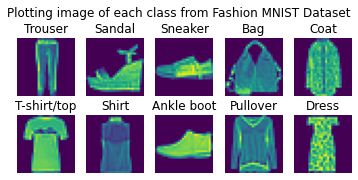

In [ ]:
xtrain,xval,xtest,ytrain,yval,ytest,labels=prepare_data()
# Creating training dataset
train=np.asarray(list(zip(xtrain,ytrain)))
# plotting a single image from each class
sample_images=[]
wandb_arr=[]
i=1
plt.suptitle("Plotting image of each class from Fashion MNIST Dataset")

while(len(sample_images)!=10):
  n=random.randrange(0,len(train))
  lab_index=np.asarray(np.nonzero(train[n][1]))[0][0]
  
  if(lab_index not in sample_images):
    plt.subplot(3,5,i)
    sample_images.append(lab_index)
    plt.title(labels[lab_index])
    plt.axis(False)
    plt.imshow(train[n][0].reshape((28,28)))
    i=i+1


Plotting images via wandb

In [ ]:
#********** Plotting images via wandb************

# Enter the entity and project details from wandb.ai
wandb.init(entity="",project="")

# Loading dataset
xtrain,xval,xtest,ytrain,yval,ytest,labels=prepdata()

# Creating training dataset
train=np.asarray(list(zip(xtrain,ytrain)))


sample_images=[]
wandb_arr=[]
i=1
plt.suptitle("Plotting image of each class from Fashion MNIST Dataset")
while(len(sample_images)!=10):
  n=random.randrange(0,len(train))
  lab_index=np.asarray(np.nonzero(train[n][1]))[0][0]
  if(lab_index not in sample_images):
    sample_images.append(lab_index)
    wandb_arr.append(wandb.Image(train[n][0].reshape((28,28)),caption=labels[train[n][1]])
    i=i+1
wandb.log({"images":wandb_arr})
wandb.finish()


<h3> Defining Various Utility functions</h3>

<h4> Initialization Functions</h4>

In [3]:

def Xavier(layer_sizes):
  params = {}
  for i in range(1,len(layer_sizes)):
      norm_xav=np.sqrt(6)/np.sqrt(layer_sizes[i]+layer_sizes[i-1])
      params["w"+str(i)]=np.random.randn(layer_sizes[i],layer_sizes[i-1])*norm_xav
      params["b"+str(i)]=np.zeros((layer_sizes[i],1))
  
  return params




In [4]:
def Random(layer_sizes):
  params = {}
  for i in range(1,len(layer_sizes)):
      params["w"+str(i)]=0.01*np.random.randn(layer_sizes[i],layer_sizes[i-1])
      params["b"+str(i)]=0.01*np.random.randn(layer_sizes[i],1)

  return params

<h4> Activation Functions </h4>

In [5]:
def sigmoid(pre_act):
  try:
    return (1.0/(1.0+np.exp(-pre_act)))
  except:
    print("error in sigmoid")

In [6]:
def tanh(pre_act):
  return (np.tanh(pre_act))


In [7]:
def relu(pre_act):
  return (np.maximum(0,pre_act))

In [8]:
def softmax(x):
  try:
    return(np.exp(x)/np.sum(np.exp(x)))
  except:
    print("error in softmax")

<h4> Derivatives of Activation Functions </h4>

In [9]:
def sigmoid_derivative(x):
  return sigmoid(x)*(1-sigmoid(x))

In [10]:
def tanh_derivative(x):
  return 1.0 -tanh(x)**2


In [11]:
def relu_derivative(x):
  return 1. * (x>0)

In [12]:
def softmax_derivative(x):
  return softmax(x) * (1-softmax(x))

In [13]:
def derivative(A, activation):
  if activation == "sigmoid":
    return sigmoid_derivative(A)
  elif activation == "tanh":
    return tanh_derivative(A)
  elif activation == "relu":
    return relu_derivative(A)


<h4>Loss Functions</h4>

In [14]:
def MSE(y, y_hat):
  error = np.sum(((y - y_hat)**2) / (2 * len(y)))
  return error

In [15]:
def CrossEntropy(y, y_hat):
  error = - np.sum( np.multiply(y , np.log(y_hat)))/len(y)
  return error

In [16]:

# Calculating loss 
def loss_calc(loss_name, y, y_hat, lambd, layer_sizes, parameters):
  error=0
  if(loss_name == "sse"):
    error=MSE(y, y_hat)
  elif(loss_name == "cross_entropy"):
    error=CrossEntropy(y, y_hat)
    #error = -np.sum(np.sum(y_t*np.log(y_hat)))

  #For L2 Regularization
  regularized_error = 0.0
  for i in range(len(layer_sizes)-1, 0, -1):
    regularized_error += (np.sum(parameters["w"+str(i)]))**2
  regularized_error = error + ((lambd/(2*len(y)))*(regularized_error))


  return regularized_error

<h2> Initialization of Neural Network</h2>

In [17]:
def nn_init(layer_sizes, init_type = "random"):
  # Layer Sizes denotes the number of neurons per layer
  # 784 is for the input layer. 
  # 32 is for the hidden layers. 
  # 10 is for the output layers

  # initializing parameters for the neural network, 
  params={}
  if(init_type=="xavier"):
    params = Xavier(layer_sizes)

  elif(init_type=="random"):
    params = Random(layer_sizes)

  else:
    print("Enter a valid weight initilization type")

  return params


<h2> Forward Propagation</h2>

In [18]:
def forward_prop(X,y,params,active,layer_sizes):
  
  # Extracting only the image data not the label for the image data
  out=copy.deepcopy(X)
  out=out.reshape(-1,1)
  
  #These are stored just to make it easy to keep track of the indices along with layers.
  h=[out] # To save the activations for each neuron in a layer
  a=[out] # To save the preactivation for each neuron in a layer

  if(active=="sigmoid"):
    for i in range(1,len(layer_sizes)-1):
      weights=params["w"+str(i)]
      biases=params["b"+str(i)]
      
      out=np.dot(weights,h[i-1])+biases
      a.append(out)
      post_a=sigmoid(out)
      h.append(post_a)
  
  elif(active=="tanh"):
    for i in range(1,len(layer_sizes)-1):
      weights=params["w"+str(i)]
      biases=params["b"+str(i)]
      
      out=np.dot(weights,h[i-1])+biases
      a.append(out)
      post_a=tanh(out)
      h.append(post_a)
  
  elif(active=="relu"):
    for i in range(1,len(layer_sizes)-1):
      weights=params["w"+str(i)]
      biases=params["b"+str(i)]
      
      out=np.dot(weights,h[i-1])+biases
      a.append(out)
      post_a=relu(out)
      h.append(post_a)       
  else:
    print("Enter a valid activation function") 

  # Final step for forward propagation, using softmax.
  weights=params["w"+str(len(layer_sizes)-1)]
  biases=params["b"+str(len(layer_sizes)-1)]
  
  out=np.dot(weights,h[len(layer_sizes)-2])+biases
  a.append(out)
  y_hat=softmax(out)
  h.append(y_hat)
  
  
  #in h we  are storing values for layers right from input till output
  #h0 is input
  #in a we are storing values for layers right from input till output
  #a0 is input

  return h,a,y_hat

<h2>Back Propagation</h2>

In [19]:
def back_prop(y, y_hat, h, a, params, loss_type, layer_sizes, activation):
  
  #here both y_hat and y are assumed to be column vectors



  grad = {}

  if loss_type == "squared_error":
    grad["dh"+str(len(layer_sizes)-1)] = (y_hat - y)
    grad["da"+str(len(layer_sizes)-1)] = (y_hat - y) * softmax_derivative(a[len(layer_sizes)-1])

  elif loss_type == 'cross_entropy':
    #Here actually it should be one hot vector. But y does the same job
    grad["da"+str(len(layer_sizes)-1)] = -(y-y_hat)
    grad["dh"+str(len(layer_sizes)-1)] = -(y/y_hat)

  for i in range(len(layer_sizes)-1, 0, -1 ):
    #print(i)
    #Not considering L2 Regularization here. Instead will cumulate in the update section
    grad["dw"+str(i)] = np.dot(grad["da"+str(i)], np.transpose(h[i-1]))
    grad["db"+str(i)] = grad["da"+str(i)]

    if i > 1:
      grad["dh"+str(i-1)] = np.dot(np.transpose(params["w"+str(i)]), grad["da"+str(i)])
      grad["da"+str(i-1)] = np.multiply(grad["dh" + str(i-1)], derivative(a[i-1],activation))
 
  return grad



Function to calculate gradients, batchwise

In [20]:
def grad_calculate_batchwise(X,Y,parameters,activation,layers,loss_function):
  grads={}
  grads.clear()
  #iterate over all the points in the current batch
  for j in range(len(X)):
    y = np.reshape(Y[j], (-1,1))
    #Feed forward the data point
    h,a,y_hat = forward_prop(X[j], y, parameters, activation, layers)
    #backpropagate the error.
    new_grads = back_prop(y,y_hat, h,a, parameters, loss_function, layers, activation)
    #keep collecting the gradients for all the data (since vanilla GD)
    if j == 0:
      grads = copy.deepcopy(new_grads)
    else:
      for k in range(len(layers)-1,0,-1):
        grads["dw"+str(k)] += new_grads["dw"+str(k)]
        grads["db"+str(k)] += new_grads["db"+str(k)]
  
  return grads

<h2>Different Optimization Functions</h2>

<h3> Mini Batch Gradient Descent </h3>

In [21]:
def mini_batch_gd(X_train, y_train, eta, max_epochs, layers, mini_batch_size, lambd, loss_function, activation, parameters):
  #parameters = nn_init(layers, 'random')
  
  grads={}
  err_list = []
  
  #iterate till max epochs
  for t in tqdm(range(max_epochs)):


    #iterate over all batches
    for i in range(0, len(X_train), mini_batch_size):

      grads.clear()

      X = X_train[i:i + mini_batch_size]
      Y = y_train[i:i + mini_batch_size]
      
      grads=grad_calculate_batchwise(X,Y,parameters,activation,layers,loss_function)
      
    
      #Updating the parameters once every one batch
      for j in range(len(layers)-1,0,-1):
        parameters["w"+str(j)] = (1-((eta*lambd)/mini_batch_size))*parameters["w"+str(j)] - (eta * grads["dw"+str(j)])
        parameters["b"+str(j)] = parameters["b"+str(j)] - (eta * grads["db"+str(j)])

    res = predict(X_train,y_train,parameters, activation, layers)
    err = loss_calc(loss_function, y_train, res, lambd, layers, parameters )
    err_list.append(err)

  return parameters, err_list

<h3> Momentum Based Gradient Descent </h3>

In [22]:
def momentum_gd(X_train,y_train, eta, max_epochs, layers, mini_batch_size, lambd, loss_function, activation, parameters ):
  #parameters = nn_init(layers, 'random')
  
  grads={}
  err_list = []
  update_history = {}
  gamma = 0.9 #Not treating this as a hyperparameter

  #iterate till max epochs
  for t in tqdm(range(max_epochs)):


    #iterate over all batches
    for i in range(0, len(X_train), mini_batch_size):

      grads.clear()

      X = X_train[i:i + mini_batch_size]
      Y = y_train[i:i + mini_batch_size]
      
      grads=grad_calculate_batchwise(X,Y,parameters,activation,layers,loss_function)
      
      #Storing the update history for each parameter.
      if i == 0 :
        for j in range(len(layers)-1, 0, -1):
          update_history["w"+str(j)] = eta*grads["dw"+str(j)]
          update_history["b"+str(j)] = eta*grads["db"+str(j)]
      else:
        for j in range(len(layers)-1, 0, -1):
          update_history["w"+str(j)] = (gamma*update_history["w"+str(j)]) + (eta*grads["dw"+str(j)])
          update_history["b"+str(j)] = (gamma*update_history["b"+str(j)]) + (eta*grads["db"+str(j)])

    
      #Updating the parameters once every one batch with the update_history
      for j in range(len(layers)-1,0,-1):
        parameters["w"+str(j)] = (1-((eta*lambd)/mini_batch_size))*parameters["w"+str(j)] - update_history["w"+str(j)]
        parameters["b"+str(j)] = parameters["b"+str(j)] - update_history["b"+str(j)]

    res = predict(X_train,y_train,parameters, activation, layers)
    err = loss_calc(loss_function, y_train, res, lambd, layers, parameters )
    err_list.append(err)

  return parameters, err_list

<h3> Nesterov Accelerated Gradient Descent</h3>

In [23]:
def nesterov_gd(X_train,y_train, eta, max_epochs, layers, mini_batch_size, lambd, loss_function, activation, parameters ):
 
  grads={}
  err_list = []
  update_history = {}
  param_lookahead = {}
  gamma = 0.9 #not treating this as a hyperparameter.

  #iterate till max epochs
  for t in tqdm(range(max_epochs)):


    #iterate over all batches
    for i in range(0, len(X_train), mini_batch_size):

      grads.clear()

      #If it is the first batch, we still dont have the previous history.
      #So, lookahead will be same as the current parameters
      if i==0:
        param_lookahead = copy.deepcopy(parameters)
      
      #If its not the first batch then we calculate lookahead according to
      #the formula.
      else:
        for j in range(len(layers)-1, 0, -1):
          param_lookahead['w'+str(j)] = parameters['w'+str(j)] + (gamma*update_history["w"+str(j)])
                                                                  

      X = X_train[i:i + mini_batch_size]
      Y = y_train[i:i + mini_batch_size]
      
      grads=grad_calculate_batchwise(X,Y,parameters,activation,layers,loss_function)
      
      #Storing the update history for each parameter.

      #If its the first batch, we dont have any update history yet. So, it will
      #be same as the eta*gradients
      if i == 0 :
        for j in range(len(layers)-1, 0, -1):
          update_history["w"+str(j)] = eta*grads["dw"+str(j)]
          update_history["b"+str(j)] = eta*grads["db"+str(j)]
      
      #If its not the first batch, we cumulate the update history as per the 
      #formula.
      else:
        for j in range(len(layers)-1, 0, -1):
          update_history["w"+str(j)] = (gamma*update_history["w"+str(j)]) + (eta*grads["dw"+str(j)])
          update_history["b"+str(j)] = (gamma*update_history["b"+str(j)]) + (eta*grads["db"+str(j)])

    
      #Updating the parameters once every one batch with the update_history
      for j in range(len(layers)-1,0,-1):
        parameters["w"+str(j)] = (1-((eta*lambd)/mini_batch_size))*parameters["w"+str(j)] - update_history["w"+str(j)]
        parameters["b"+str(j)] = parameters["b"+str(j)] - update_history["b"+str(j)]

    res = predict(X_train,y_train,parameters, activation, layers)
    err = loss_calc(loss_function, y_train, res, lambd, layers, parameters )
    err_list.append(err)

  return parameters, err_list

<h3> RMSprop</h3>

In [24]:
#*********code for rmsprop***************
def rmsprop(X_train,y_train, eta, max_epochs, layers, mini_batch_size, lambd, loss_function, activation, parameters ):
    
  grads={}
  err_list = []
  update_history = {}
  v={}
  
  # Initializing update_history
  for i in range(len(layers)-1,0,-1):
    update_history["w"+str(i)]=np.zeros((layers[i],layers[i-1]))
    update_history["b"+str(i)]=np.zeros((layers[i],1))
  # Initializing v 
  for i in range(len(layers)-1,0,-1):
    v["w"+str(i)]=np.zeros((layers[i],layers[i-1]))
    v["b"+str(i)]=np.zeros((layers[i],1))
  
  beta = 0.9 
  epsilon=1e-8

  #iterate till max epochs
  for t in tqdm(range(max_epochs)):
   
    #iterate over all batches
    for i in range(0, len(X_train), mini_batch_size):
      grads.clear()

      X = X_train[i:i + mini_batch_size]
      Y = y_train[i:i + mini_batch_size]
      
      grads=grad_calculate_batchwise(X,Y,parameters,activation,layers,loss_function)
        
      for iq in range(len(layers)-1,0,-1):
        v["w"+str(iq)]=beta*v["w"+str(iq)]+(1-beta)*grads["dw"+str(iq)]**2
        v["b"+str(iq)]=beta*v["b"+str(iq)]+(1-beta)*grads["db"+str(iq)]**2
          
        update_history["w"+str(iq)]=eta*np.multiply(np.reciprocal(np.sqrt(v["w"+str(iq)]+epsilon)),grads["dw"+str(iq)])
        update_history["b"+str(iq)]=eta*np.multiply(np.reciprocal(np.sqrt(v["b"+str(iq)]+epsilon)),grads["db"+str(iq)])

      for j in range(len(layers)-1,0,-1):
        parameters["w"+str(j)] = (1-((eta*lambd)/mini_batch_size))*parameters["w"+str(j)] - update_history["w"+str(j)]
        parameters["b"+str(j)] = parameters["b"+str(j)] - update_history["b"+str(j)]

    res = predict(X_train,y_train,parameters, activation, layers)
    err = loss_calc(loss_function, y_train, res, lambd, layers, parameters )
    err_list.append(err)

  return parameters, err_list





<h3> Adam </h3>

In [25]:
#*********code for adam***************
def adam(X_train,y_train, eta, max_epochs, layers, mini_batch_size, lambd, loss_function, activation, parameters ):
    
  grads={}
  err_list = []
  update_history = {}
  v={}
  m={}

  # Initializing update_history
  for i in range(len(layers)-1,0,-1):
    update_history["w"+str(i)]=np.zeros((layers[i],layers[i-1]))
    update_history["b"+str(i)]=np.zeros((layers[i],1))
  # Initializing m 
  for i in range(len(layers)-1,0,-1):
    m["w"+str(i)]=np.zeros((layers[i],layers[i-1]))
    m["b"+str(i)]=np.zeros((layers[i],1))
  # Initializing v 
  for i in range(len(layers)-1,0,-1):
    v["w"+str(i)]=np.zeros((layers[i],layers[i-1]))
    v["b"+str(i)]=np.zeros((layers[i],1))
  
  beta1 = 0.9 
  beta2=0.999
  epsilon=1e-8

  #iterate till max epochs
  for t in tqdm(range(max_epochs)):


    #iterate over all batches
    for i in range(0, len(X_train), mini_batch_size):
      grads.clear()
      X = X_train[i:i + mini_batch_size]
      Y = y_train[i:i + mini_batch_size]
      
      grads=grad_calculate_batchwise(X,Y,parameters,activation,layers,loss_function)
      
      for iq in range(len(layers)-1,0,-1):
          m["w"+str(iq)]=beta1*m["w"+str(iq)]+(1-beta1)*grads["dw"+str(iq)]
          m["b"+str(iq)]=beta1*m["b"+str(iq)]+(1-beta1)*grads["db"+str(iq)]
          
          v["w"+str(iq)]=beta2*v["w"+str(iq)]+(1-beta2)*(grads["dw"+str(iq)])**2
          v["b"+str(iq)]=beta2*v["b"+str(iq)]+(1-beta2)*(grads["db"+str(iq)])**2

          # Bias Correction:
          # calculating mt_hat and vt_hat for weights and biases 
          mw_hat=m["w"+str(iq)]/(1-np.power(beta1,t+1))
          mb_hat=m["b"+str(iq)]/(1-np.power(beta1,t+1))

          vw_hat=v["w"+str(iq)]/(1-np.power(beta2,t+1))
          vb_hat=v["b"+str(iq)]/(1-np.power(beta2,t+1))
          
          update_history["w"+str(iq)]=eta*np.multiply(np.reciprocal(np.sqrt(vw_hat+epsilon)),mw_hat)
          update_history["b"+str(iq)]=eta*np.multiply(np.reciprocal(np.sqrt(vb_hat+epsilon)),mb_hat)

      for j in range(len(layers)-1,0,-1):
          parameters["w"+str(j)] = (1-((eta*lambd)/mini_batch_size))*parameters["w"+str(j)] - update_history["w"+str(j)]
          parameters["b"+str(j)] = parameters["b"+str(j)] - update_history["b"+str(j)]

    res = predict(X_train,y_train,parameters, activation, layers)
    err = loss_calc(loss_function, y_train, res, lambd, layers, parameters )
    err_list.append(err)

  return parameters, err_list





<h3>NAdam</h3>

In [26]:
#*********code for nadam***************

def n_adam(X_train,y_train, eta, max_epochs, layers, mini_batch_size, lambd, loss_function, activation, parameters ):
    
  grads={}
  err_list = []
  update_history = {}
  v={}
  m={}

  # Initializing update_history
  for i in range(len(layers)-1,0,-1):
    update_history["w"+str(i)]=np.zeros((layers[i],layers[i-1]))
    update_history["b"+str(i)]=np.zeros((layers[i],1))
  # Initializing m 
  for i in range(len(layers)-1,0,-1):
    m["w"+str(i)]=np.zeros((layers[i],layers[i-1]))
    m["b"+str(i)]=np.zeros((layers[i],1))
  # Initializing v 
  for i in range(len(layers)-1,0,-1):
    v["w"+str(i)]=np.zeros((layers[i],layers[i-1]))
    v["b"+str(i)]=np.zeros((layers[i],1))
  
  beta1 = 0.9 
  beta2=0.999
  epsilon=1e-8

  #iterate till max epochs
  for t in tqdm(range(max_epochs)):


    #iterate over all batches
    for i in range(0, len(X_train), mini_batch_size):

      grads.clear()

      X = X_train[i:i + mini_batch_size]
      Y = y_train[i:i + mini_batch_size]
      
      grads=grad_calculate_batchwise(X,Y,parameters,activation,layers,loss_function)
 
      for iq in range(len(layers)-1,0,-1):
          m["w"+str(iq)]=beta1*m["w"+str(iq)]+(1-beta1)*grads["dw"+str(iq)]
          m["b"+str(iq)]=beta1*m["b"+str(iq)]+(1-beta1)*grads["db"+str(iq)]
          
          v["w"+str(iq)]=beta2*v["w"+str(iq)]+(1-beta2)*(grads["dw"+str(iq)])**2
          v["b"+str(iq)]=beta2*v["b"+str(iq)]+(1-beta2)*(grads["db"+str(iq)])**2

          # Bias Correction:
          # calculating mt_hat and vt_hat for weights and biases 
          mw_hat=m["w"+str(iq)]/(1-np.power(beta1,t+1))
          mb_hat=m["b"+str(iq)]/(1-np.power(beta1,t+1))

          vw_hat=v["w"+str(iq)]/(1-np.power(beta2,t+1))
          vb_hat=v["b"+str(iq)]/(1-np.power(beta2,t+1))
          
          update_history["w"+str(iq)]=eta*np.multiply(np.reciprocal(np.sqrt(vw_hat+epsilon)),(beta1*mw_hat+(1-beta1)*grads["dw"+str(iq)]))*(1/(1-np.power(beta1,t+1)))
          update_history["b"+str(iq)]=eta*np.multiply(np.reciprocal(np.sqrt(vb_hat+epsilon)),(beta1*mb_hat+(1-beta1)*grads["db"+str(iq)]))*(1/(1-np.power(beta1,t+1)))

      for j in range(len(layers)-1,0,-1):
          parameters["w"+str(j)] = (1-((eta*lambd)/mini_batch_size))*parameters["w"+str(j)] - update_history["w"+str(j)]
          parameters["b"+str(j)] = parameters["b"+str(j)] - update_history["b"+str(j)]

    res = predict(X_train,y_train,parameters, activation, layers)
    err = loss_calc(loss_function, y_train, res, lambd, layers, parameters )
    err_list.append(err)

  return parameters, err_list





<h2>Fit</h2>
Function to train the neural network

In [27]:
def fit(X_train, y_train, layer_sizes, learning_rate = 0.0001, initialization_type = "random", activation_function = "sigmoid", loss_function = "cross_entropy", mini_batch_Size = 32, max_epochs = 5, lambd = 0, optimization_function = mini_batch_gd): 



  parameters = nn_init(init_type = initialization_type, layer_sizes = layer_sizes)
  parameters, error_list = optimization_function(X_train, y_train,learning_rate, max_epochs, layer_sizes, mini_batch_Size, lambd, loss_function, activation_function, parameters)
  print(error_list)

  return parameters




<h2> Predict </h2>
Function to predict the labels after training the model

In [28]:
def predict(X_train,y_train,parameters,activation,layer_sizes):

  '''This function is used to simple take a model parameters
      and run the data points using forward prop, and return the outputs 
      of all the input data points'''

  result = []

  for i in range(len(X_train)):
    h,a,y_hat = forward_prop(X_train[i], y_train[i], parameters, activation, layer_sizes)

    #converting y_hat to a 1d array to match with the y
    y_hat = y_hat.flatten()
    result.append(y_hat)
  
  return result


<h2>Calling all the functions</h2>

In [ ]:

layer_sizes = [784,32,32,10]
learning_rate = 0.0001
initialization_type = "xavier"
activation_function = "sigmoid"
loss_function = "cross_entropy"
mini_batch_size = 32
max_epochs = 20
lambd = 0 
optimization_function = adam


X_train, X_val, X_test, y_train, y_val, y_test, labels = prepare_data()

parameters = fit(X_train, y_train, layer_sizes, learning_rate, initialization_type, activation_function, loss_function, mini_batch_size, max_epochs, lambd, optimization_function)

res = predict(X_train,y_train, parameters, activation_function, layer_sizes)
err = loss_calc(loss_function, y_train, res, lambd, layer_sizes, parameters)
print("Train loss is :",err)


res = predict(X_test,y_test, parameters, activation_function, layer_sizes)
err = loss_calc(loss_function, y_test, res, lambd, layer_sizes, parameters)
print("Test loss is :",err)


Number of data points in train data (initially) -  60000
Number of data points in test data (initially) -  10000
Shape of each image - 28x28
shape of each image (1D) -  784


100%|██████████| 20/20 [06:34<00:00, 19.72s/it]


[1.7050021298563696, 1.4918626985715064, 1.3644020938816455, 1.263735134962053, 1.177482686672871, 1.1074833105309125, 1.0466684828954094, 0.9943360227777963, 0.9486076197625425, 0.9081688909455631, 0.8719933514681826, 0.8394518441863489, 0.8098616702106104, 0.7820565541959578, 0.7576985512586029, 0.735478536597561, 0.7150609165151275, 0.6962162673217258, 0.6787638228873148, 0.6625565202508746]
Train loss is : 0.6625565202508746
Test loss is : 0.6818287390722255


In [ ]:

layer_sizes = [784,32,32,10]
learning_rate = 0.0001
initialization_type = "xavier"
activation_function = "sigmoid"
loss_function = "cross_entropy"
mini_batch_size = 32
max_epochs = 20
lambd = 0 
optimization_function = n_adam


X_train, X_val, X_test, y_train, y_val, y_test, labels = prepare_data()

parameters = fit(X_train, y_train, layer_sizes, learning_rate, initialization_type, activation_function, loss_function, mini_batch_size, max_epochs, lambd, optimization_function)

res = predict(X_train,y_train, parameters, activation_function, layer_sizes)
err = loss_calc(loss_function, y_train, res, lambd, layer_sizes, parameters)
print("Train loss is :",err)


res = predict(X_test,y_test, parameters, activation_function, layer_sizes)
err = loss_calc(loss_function, y_test, res, lambd, layer_sizes, parameters)
print("Test loss is :",err)


Number of data points in train data (initially) -  60000
Number of data points in test data (initially) -  10000
Shape of each image - 28x28
shape of each image (1D) -  784


100%|██████████| 20/20 [06:39<00:00, 19.96s/it]


[0.6088209769084224, 0.5523804249973134, 0.5285184353646958, 0.5142271645329473, 0.5042819353625889, 0.4967253705491029, 0.4906372046572024, 0.48552448917878577, 0.4810978723198597, 0.4771753414464648, 0.473636056563522, 0.47039626925518757, 0.4673958813740041, 0.46459051288077574, 0.461946598478084, 0.4594382354892736, 0.45704508862681054, 0.4547509564948635, 0.4525427658327407, 0.4504098500635978]
Train loss is : 0.4504098500635978
Test loss is : 0.4820588075482052
